In [1]:
import requests
import time
import jwt
import sqlite3
import pandas as pd

def generate_jwt_token(client_id, client_secret):
    now = int(time.time())
    payload = {
        "iss": client_id,
        "sub": client_id,
        "iat": now,
        "exp": now + 3600,  # Token expires in 1 hour
    }
    jwt_token = jwt.encode(payload, client_secret, algorithm='HS256')
    return jwt_token

def get_access_token(client_id, client_secret):
    jwt_token = generate_jwt_token(client_id, client_secret)

    token_endpoint = "https://rest.arbeitsagentur.de/oauth/gettoken_cc"
    headers = {
        "Content-Type": "application/x-www-form-urlencoded",
    }
    data = {
        "grant_type": "client_credentials",
        "client_id": client_id,
        "client_secret": client_secret
    }

    response = requests.post(token_endpoint, headers=headers, data=data)

    if response.status_code == 200:
        return response.json()["access_token"]
    else:
        raise Exception(f"Failed to get access token. Status code: {response.status_code}")

def fetch_entgelte_data(token, kldb_schluessel, params):
    headers = {
        "Authorization": f"Bearer {token}"
    }
    url = f"https://rest.arbeitsagentur.de/infosysbub/entgeltatlas/pc/v1/entgelte/{kldb_schluessel}"
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    return data

def create_table(db_connection):
    cursor = db_connection.cursor()
    cursor.execute('''CREATE TABLE IF NOT EXISTS entgelte (
                        id INTEGER PRIMARY KEY AUTOINCREMENT,
                        kldb TEXT,
                        region_id INTEGER,
                        region_bezeichnung TEXT,
                        region_schluessel TEXT,
                        region_oberRegionId TEXT,
                        region_oberRegionBezeichnung TEXT,
                        region_beitragsBemessungsGrenze INTEGER,
                        gender_id INTEGER,
                        gender_bezeichnung TEXT,
                        ageCategory_id INTEGER,
                        ageCategory_bezeichnung TEXT,
                        performanceLevel_id INTEGER,
                        performanceLevel_bezeichnung TEXT,
                        branche_id INTEGER,
                        branche_bezeichnung TEXT,
                        entgelt INTEGER,
                        entgeltQ25 INTEGER,
                        entgeltQ75 INTEGER,
                        besetzung INTEGER
                    )''')

def insert_data_into_db(data, db_connection):
    cursor = db_connection.cursor()
    for entry in data:
        if all(value is not None for value in entry.values()):
            values = (
                entry["kldb"],
                entry["region"]["id"],
                entry["region"]["bezeichnung"],
                entry["region"]["schluessel"],
                entry["region"]["oberRegionId"],
                entry["region"]["oberRegionBezeichnung"],
                entry["region"]["beitragsBemessungsGrenze"],
                entry["gender"]["id"],
                entry["gender"]["bezeichnung"],
                entry["ageCategory"]["id"],
                entry["ageCategory"]["bezeichnung"],
                entry["performanceLevel"]["id"],
                entry["performanceLevel"]["bezeichnung"],
                entry["branche"]["id"],
                entry["branche"]["bezeichnung"],
                entry["entgelt"],
                entry["entgeltQ25"],
                entry["entgeltQ75"],
                entry["besetzung"]
            )

            cursor.execute('''INSERT INTO entgelte (
                kldb,
                region_id,
                region_bezeichnung,
                region_schluessel,
                region_oberRegionId,
                region_oberRegionBezeichnung,
                region_beitragsBemessungsGrenze,
                gender_id,
                gender_bezeichnung,
                ageCategory_id,
                ageCategory_bezeichnung,
                performanceLevel_id,
                performanceLevel_bezeichnung,
                branche_id,
                branche_bezeichnung,
                entgelt,
                entgeltQ25,
                entgeltQ75,
                besetzung
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)''', values)

    db_connection.commit()

def main():
    client_id = "c4f0d292-9d0f-4763-87dd-d3f9e78fb006"
    client_secret = "566c4dd6-942f-4cda-aad6-8d611c577107"

    # Read KldB-Schlüssel values from Excel file into a DataFrame
    df = pd.read_excel('kldb.xlsx', nrows=100)  # Read only the first 100 records
    kldb_schluessel_list = df['kldb_id'].tolist()

    # Get the access token
    token = get_access_token(client_id, client_secret)

    # Fetch entgelte data
    params = {
        "r": "1-30",    # Fetch data for region IDs from 1 to 30
        "pageSize": 10000  # Increase the page size to 100 (adjust as needed)
    }

    # Create SQLite database connection
    db_connection = sqlite3.connect('weiterbildung_analysis.db')  # Use the updated database name 'full.db'

    # Create table if not exists
    create_table(db_connection)

    for kd in kldb_schluessel_list:
        try:
            for region_id in range(1, 31):
                entgelte_data = fetch_entgelte_data(token, kd, {"r": region_id, "pageSize": params["pageSize"]})
                insert_data_into_db(entgelte_data, db_connection)

                print(f"Data fetched and saved to SQLite database for KldB-Schlüssel: {kd}")
        except Exception as e:
            print(f"Error: {e}")
            db_connection.rollback()

    db_connection.close()

if __name__ == "__main__":
    main()


Data fetched and saved to SQLite database for KldB-Schlüssel: 111
Data fetched and saved to SQLite database for KldB-Schlüssel: 111
Data fetched and saved to SQLite database for KldB-Schlüssel: 111


KeyboardInterrupt: 

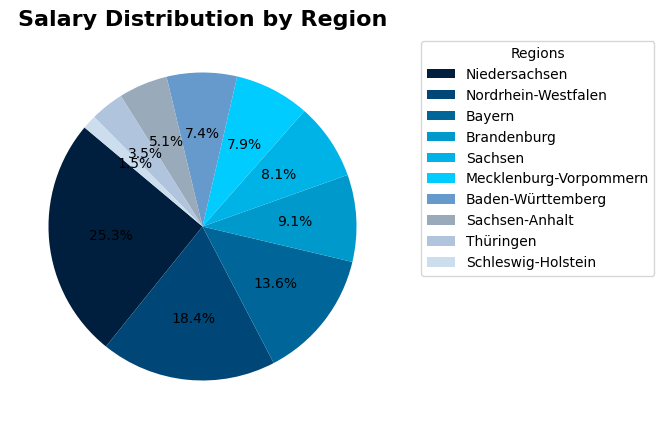

In [1]:
import sqlite3
import matplotlib.pyplot as plt

# Connect to your SQLite database
db_connection = sqlite3.connect('weiterbildung_analysis.db')

# Tuple of German region names to exclude from the pie chart
exclude_regions = ('Norddeutschland', 'Süddeutschland', 'Deutschland', 'Westdeutschland', 'Ostdeutschland')

# Query the database to retrieve data for the pie chart
cursor = db_connection.cursor()
cursor.execute('''
    SELECT region_bezeichnung, SUM(entgelt) AS total_salary
    FROM entgelte
    WHERE region_bezeichnung NOT IN (?, ?, ?, ?, ?)
    GROUP BY region_bezeichnung
    ORDER BY total_salary DESC
    LIMIT 10  -- You can adjust the number of top regions to include
''', exclude_regions)

# Fetch the data from the query result
data = cursor.fetchall()

# Separate the region names and total salaries into lists
regions = [row[0] for row in data]
total_salaries = [row[1] for row in data]

# Define custom colors
colors = ['#001f3f', '#004777', '#006699', '#0099cc', '#00b3e6', '#00ccff', '#6699cc', '#99aabb', '#b0c4de', '#ccddee', '#e0e0e0', '#f2f2f2', '#f5f5f5']

# Create a pie chart with custom colors
plt.figure(figsize=(18, 5))
plt.pie(total_salaries, labels=None, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Salary Distribution by Region', fontsize=16, fontweight='bold')

# Create a legend on the side with region names
plt.legend(regions, title="Regions", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the pie chart
plt.show()

# Close the database connection
db_connection.close()


In [ ]:
import sqlite3
import matplotlib.pyplot as plt

# Connect to your SQLite database
db_connection = sqlite3.connect('weiterbildung_analysis.db')

# Execute the SQL query to retrieve job counts by age group
cursor = db_connection.cursor()
cursor.execute('''
    SELECT ageCategory_bezeichnung, COUNT(*) AS job_count
    FROM entgelte
    WHERE ageCategory_bezeichnung IN ('unter 25', '25 bis unter 55', 'ab 55')
    GROUP BY ageCategory_bezeichnung
    ORDER BY job_count
''')

# Fetch the data from the query result
data = cursor.fetchall()

# Separate the age groups and job counts into lists
age_groups = [row[0] for row in data]
job_counts = [row[1] for row in data]

# Define custom colors
colors = ['#8B1A1A', '#DC143C', '#FF6A6A']

# Create a pie chart with a white circle in the center (donut chart)
plt.figure(figsize=(12, 5))
plt.pie(job_counts, labels=None, colors=colors, autopct='%1.1f%%', startangle=140)
circle = plt.Circle((0, 0), 0.7, fc='white')  # Add a white circle in the center
fig = plt.gcf()
fig.gca().add_artist(circle)

# Add labels to the pie chart outside of it
plt.title('Job Opportunities by Age Group', fontsize=16, fontweight='bold')
plt.legend(age_groups, title="Age Groups", bbox_to_anchor=(1.05, 1), loc='upper left')

# Equal aspect ratio ensures that the pie is drawn as a circle
plt.axis('equal')

# Show the donut chart
plt.show()

# Close the database connection
db_connection.close()


In [ ]:
import sqlite3
import matplotlib.pyplot as plt

# Function to retrieve salary statistics for all cities (excluding negative values)
def get_salary_statistics_for_all_cities(db_connection):
    cursor = db_connection.cursor()
    cursor.execute('''
        SELECT region_bezeichnung, 
               AVG(entgelt) AS avg_entgelt, 
               AVG(entgeltQ25) AS avg_entgeltQ25, 
               AVG(entgeltQ75) AS avg_entgeltQ75
        FROM entgelte
        WHERE entgelt >= 0  -- Exclude rows with negative salaries
        GROUP BY region_bezeichnung
        ORDER BY region_bezeichnung
    ''')
    data = cursor.fetchall()
    return data

def main():
    # Create SQLite database connection
    db_connection = sqlite3.connect('weiterbildung_analysis.db')

    # Retrieve salary statistics for all cities (excluding negative values)
    city_data = get_salary_statistics_for_all_cities(db_connection)

    # Separate city names and salary statistics for visualization
    cities = [row[0] for row in city_data]
    avg_entgelt = [row[1] for row in city_data]
    avg_entgeltQ25 = [row[2] for row in city_data]
    avg_entgeltQ75 = [row[3] for row in city_data]

    # Define custom colors for the bar chart
    colors = ['#001f3f', '#006699', '#00b3e6']
    bar_width = 0.2
    index = range(len(cities))

    # Create a bar chart to visualize the data
    plt.figure(figsize=(1, 4))
    plt.bar(index, avg_entgelt, bar_width, label='Average Salary', color=colors[0])
    plt.bar([i + bar_width for i in index], avg_entgeltQ25, bar_width, label='Q25 Salary', color=colors[1])
    plt.bar([i + 2 * bar_width for i in index], avg_entgeltQ75, bar_width, label='Q75 Salary', color=colors[2])

    plt.xlabel('Cities')
    plt.ylabel('Salary')
    plt.title('Salary Statistics by City ')
    plt.xticks([i + bar_width for i in index], cities, rotation=45, ha='right')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd

# Connect to the SQLite database
db_connection = sqlite3.connect('weiterbildung_analysis.db')

# Define the SQL query to fetch data for entgelt, entgeltQ25, and entgeltQ75, excluding "gesamt" and negative values
query = """
    SELECT gender_bezeichnung, 
           AVG(CASE WHEN entgelt >= 0 THEN entgelt ELSE NULL END) as avg_salary,
           AVG(CASE WHEN entgeltQ25 >= 0 THEN entgeltQ25 ELSE NULL END) as avg_salary_Q25,
           AVG(CASE WHEN entgeltQ75 >= 0 THEN entgeltQ75 ELSE NULL END) as avg_salary_Q75
    FROM entgelte
    WHERE gender_bezeichnung IN ('Männer', 'Frauen')
    GROUP BY gender_bezeichnung
"""

# Execute the query and fetch the data into a Pandas DataFrame
df = pd.read_sql_query(query, db_connection)

# Close the database connection
db_connection.close()

# Define shades of red for the bars
colors = ['#8B1A1A', '#FF6A6A', '#DC143C']

# Create a grouped bar chart with shades of red
plt.figure(figsize=(12, 4))
bar_width = 0.25
index = range(len(df))

plt.bar(index, df['avg_salary'], bar_width, label='Average Salary (entgelt)', color=colors[0])
plt.bar([i + bar_width for i in index], df['avg_salary_Q25'], bar_width, label='Average Salary Q25 (entgeltQ25)', color=colors[1])
plt.bar([i + 2 * bar_width for i in index], df['avg_salary_Q75'], bar_width, label='Average Salary Q75 (entgeltQ75)', color=colors[2])

plt.xlabel('Gender')
plt.ylabel('Average Salary')
plt.title('Average Salary Distribution by Gender')
plt.xticks([i + bar_width for i in index], df['gender_bezeichnung'])
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [2]:
import sqlite3
import matplotlib.pyplot as plt

# Connect to your SQLite database
db_connection = sqlite3.connect('weiterbildung_analysis.db')

# Define the SQL query to calculate the average salary by industry and exclude "Gesamt"
query = """
    SELECT branche_bezeichnung AS industry,
           AVG(entgelt) AS avg_salary
    FROM entgelte
    WHERE entgelt >= 0  -- Exclude rows with negative salaries
    AND branche_bezeichnung <> 'Gesamt'  -- Exclude "Gesamt" rows
    GROUP BY branche_bezeichnung
    ORDER BY avg_salary DESC
"""

# Execute the query and fetch the data
cursor = db_connection.cursor()
cursor.execute(query)
industry_data = cursor.fetchall()

# Separate the industry names and average salaries into lists
industries = [row[0] for row in industry_data]
avg_salaries = [row[1] for row in industry_data]

# Display the highest and lowest industries
num_displayed = 5

# Split the industries and salaries into highest and lowest categories
highest_industries = industries[:num_displayed]
highest_avg_salaries = avg_salaries[:num_displayed]

lowest_industries = industries[-num_displayed:]
lowest_avg_salaries = avg_salaries[-num_displayed:]

# Create bar charts to visualize the highest and lowest industries
plt.figure(figsize=(12, 6))

# Highest Industries
plt.subplot(1, 2, 1)
plt.barh(highest_industries, highest_avg_salaries, color='skyblue')
plt.xlabel('Average Salary')
plt.ylabel('Industry')
plt.title(f'Highest {num_displayed} Industries by Average Salary')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Lowest Industries
plt.subplot(1, 2, 2)
plt.barh(lowest_industries, lowest_avg_salaries, color='salmon')
plt.xlabel('Average Salary')
plt.ylabel('Industry')
plt.title(f'Lowest {num_displayed} Industries by Average Salary ')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Close the database connection
db_connection.close()


OperationalError: no such table: entgelte